In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('tXY.csv', index_col='id');

In [2]:
df=pd.read_csv('tXY.csv', index_col='id');
train = df[0:400000];
test= df[400000:500000];
df=df.pct_change().fillna(0)

In [3]:

tXY1 = train.copy()
tXY = train.pct_change().fillna(0)
K, (N, p), Nx, Ny = 50, tXY.shape, 20000, len(test)  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(tXY.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXY.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors


taX.shape=(K,Nx,p)=(50, 20000, 7); taY=(K,Ny)=(50, 100000)


               Count           Open           High            Low  \
count  500000.000000  500000.000000  500000.000000  500000.000000   
mean        0.098520       0.000019       0.000021       0.000025   
std         0.628364       0.005538       0.005934       0.006751   
min        -0.967634      -0.125430      -0.274699      -0.616353   
25%        -0.197183      -0.003774      -0.003815      -0.003812   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.229730       0.003797       0.003817       0.003859   
max        60.068493       0.155206       0.386414       1.407025   

               Close         Volume           VWAP  
count  500000.000000  500000.000000  500000.000000  
mean        0.000019       0.369775       0.000019  
std         0.005552       1.705538       0.005523  
min        -0.123894      -0.988879      -0.098244  
25%        -0.003778      -0.345643      -0.003771  
50%         0.000000      -0.007918       0.000000  
75%    

C:\Users\ritap\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


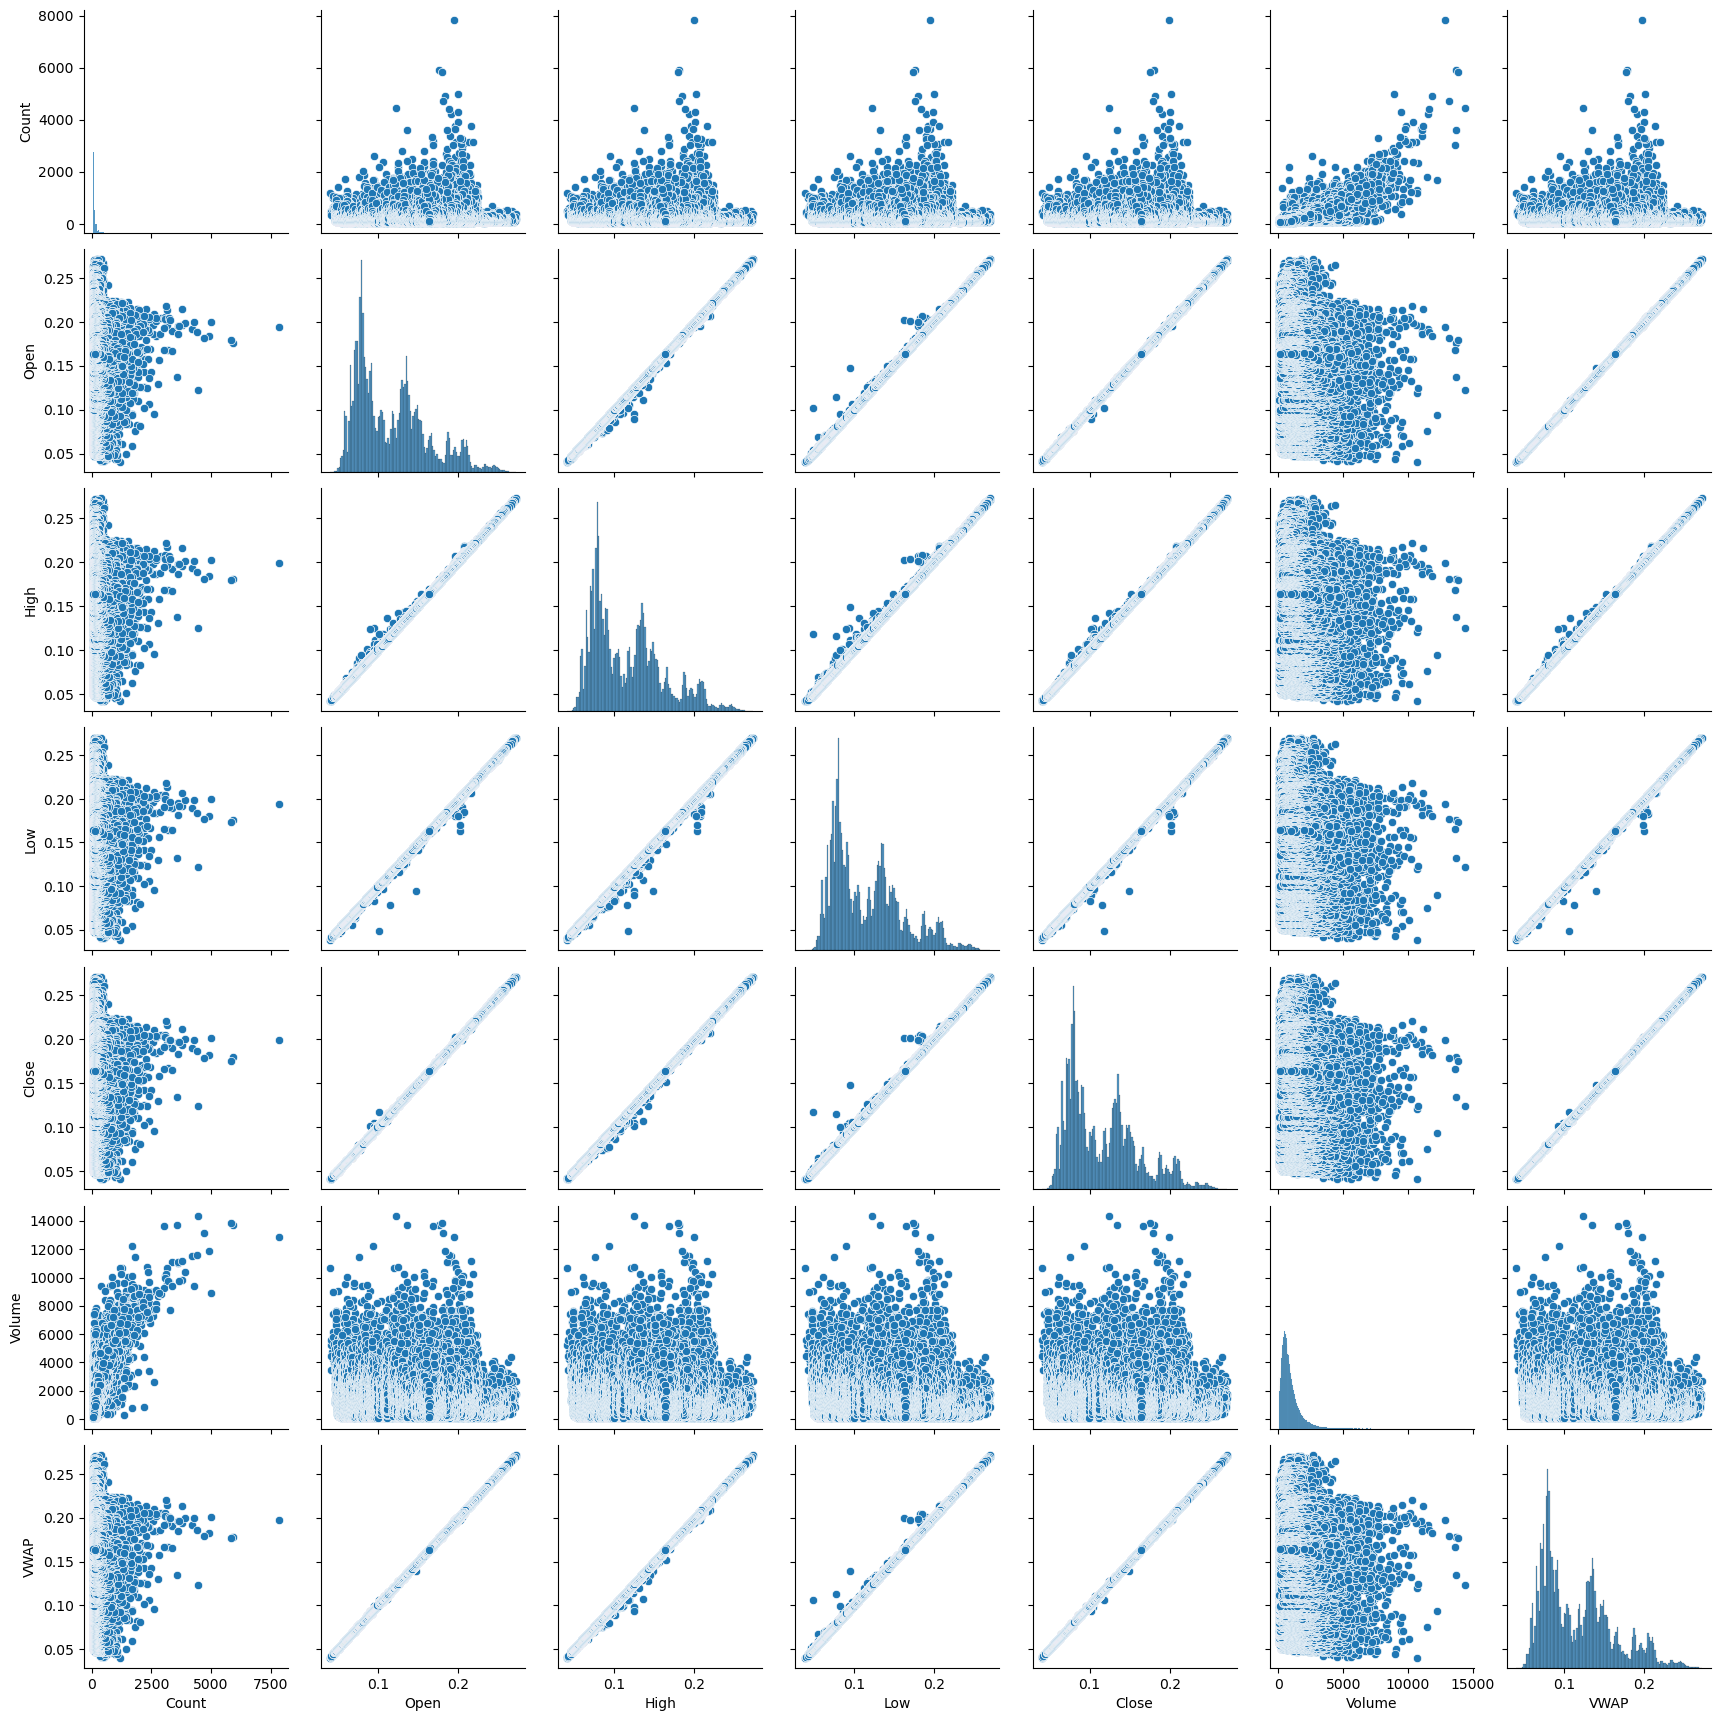

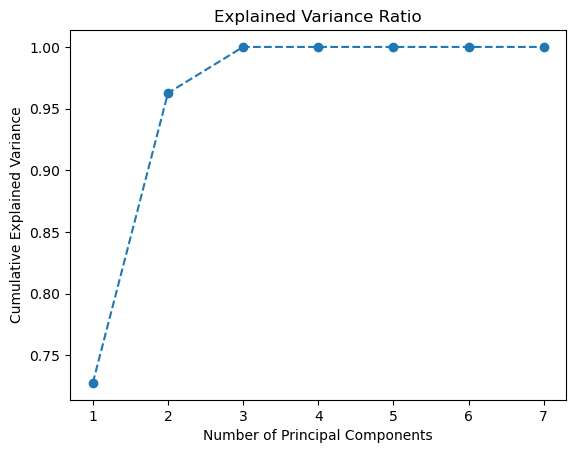

   Count    Open    High     Low   Close  Volume    VWAP       PC1       PC2
0     64  0.2017  0.2022  0.2015  0.2017     447  0.2020  4.112043 -1.433679
1     72  0.2025  0.2028  0.2023  0.2024     592  0.2024  4.174133 -1.244232
2     63  0.2019  0.2021  0.2017  0.2021     470  0.2020  4.120470 -1.420127
3     77  0.2016  0.2020  0.2012  0.2019     515  0.2015  4.129691 -1.274816
4     77  0.2016  0.2019  0.2007  0.2010     682  0.2012  4.132254 -1.113316


In [4]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']

# Explore the features
# Summary statistics, distribution, etc.
print(df.describe())

# Correlation matrix
correlation_matrix = train.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Pairplot for visualization
import seaborn as sns
sns.pairplot(train)
plt.show()

# Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()

# Choose the number of components based on the plot or a desired threshold (e.g., 95% variance explained)
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with principal components
pc_columns = [f'PC{i}' for i in range(1, n_components + 1)]
pc_df = pd.DataFrame(data=principal_components, columns=pc_columns)

# Concatenate the original DataFrame and the principal components DataFrame
final_df = pd.concat([train, pc_df], axis=1)

# Display the final DataFrame
print(final_df.head())


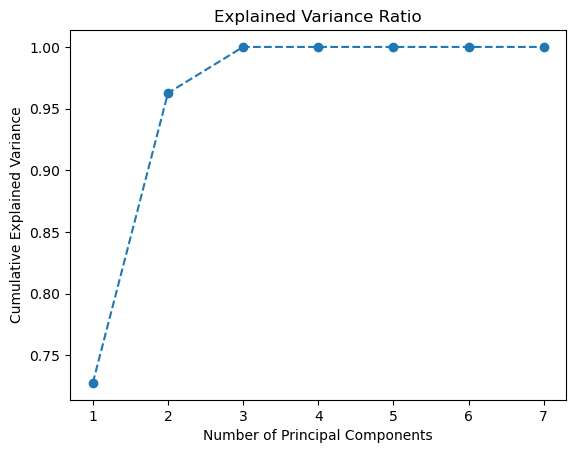

In [5]:
# Plot explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, gamma, lognorm, weibull_min
from scipy.stats import kstest
from scipy.optimize import curve_fit



# List of distributions to try fitting
distributions = [
    norm, expon, gamma, lognorm, weibull_min
]

# Fit each distribution and calculate AIC
aic_values = []
params_list = []
for col in columns:
    params_list=[]
    for distribution in distributions:
        # Fit the distribution to the data
        params = distribution.fit(train[col])
        params_list.append(params)

    # Calculate the AIC
        _, ks_p_value = kstest(train[col], distribution.name, args=params)
        aic = len(train[col]) * np.log(ks_p_value+0.0000001) + 2 * len(params)
        aic_values.append(aic)

# Select the distribution with the minimum AIC
    best_distribution_index = np.argmin(aic_values)
    best_distribution = distributions[best_distribution_index]
    best_params = params_list[best_distribution_index]


    print(f"Column "+col)
    print(f"Best-fitting distribution: {best_distribution.name}")
    print(f"Best-fitting parameters: {best_params}")


Column Open
Best-fitting distribution: norm
Best-fitting parameters: (0.11719899875, 0.04413513409940542)
Column High
Best-fitting distribution: norm
Best-fitting parameters: (0.11733491774999996, 0.04419527208735947)
Column Low
Best-fitting distribution: norm
Best-fitting parameters: (0.11705866674999997, 0.04407619888485671)
Column Close
Best-fitting distribution: norm
Best-fitting parameters: (0.11719747624999995, 0.04413593509721626)
Column Volume
Best-fitting distribution: norm
Best-fitting parameters: (909.1354125, 747.8318182358616)
Column VWAP
Best-fitting distribution: norm
Best-fitting parameters: (0.11719700675, 0.04413472939834858)


C:\Users\ritap\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


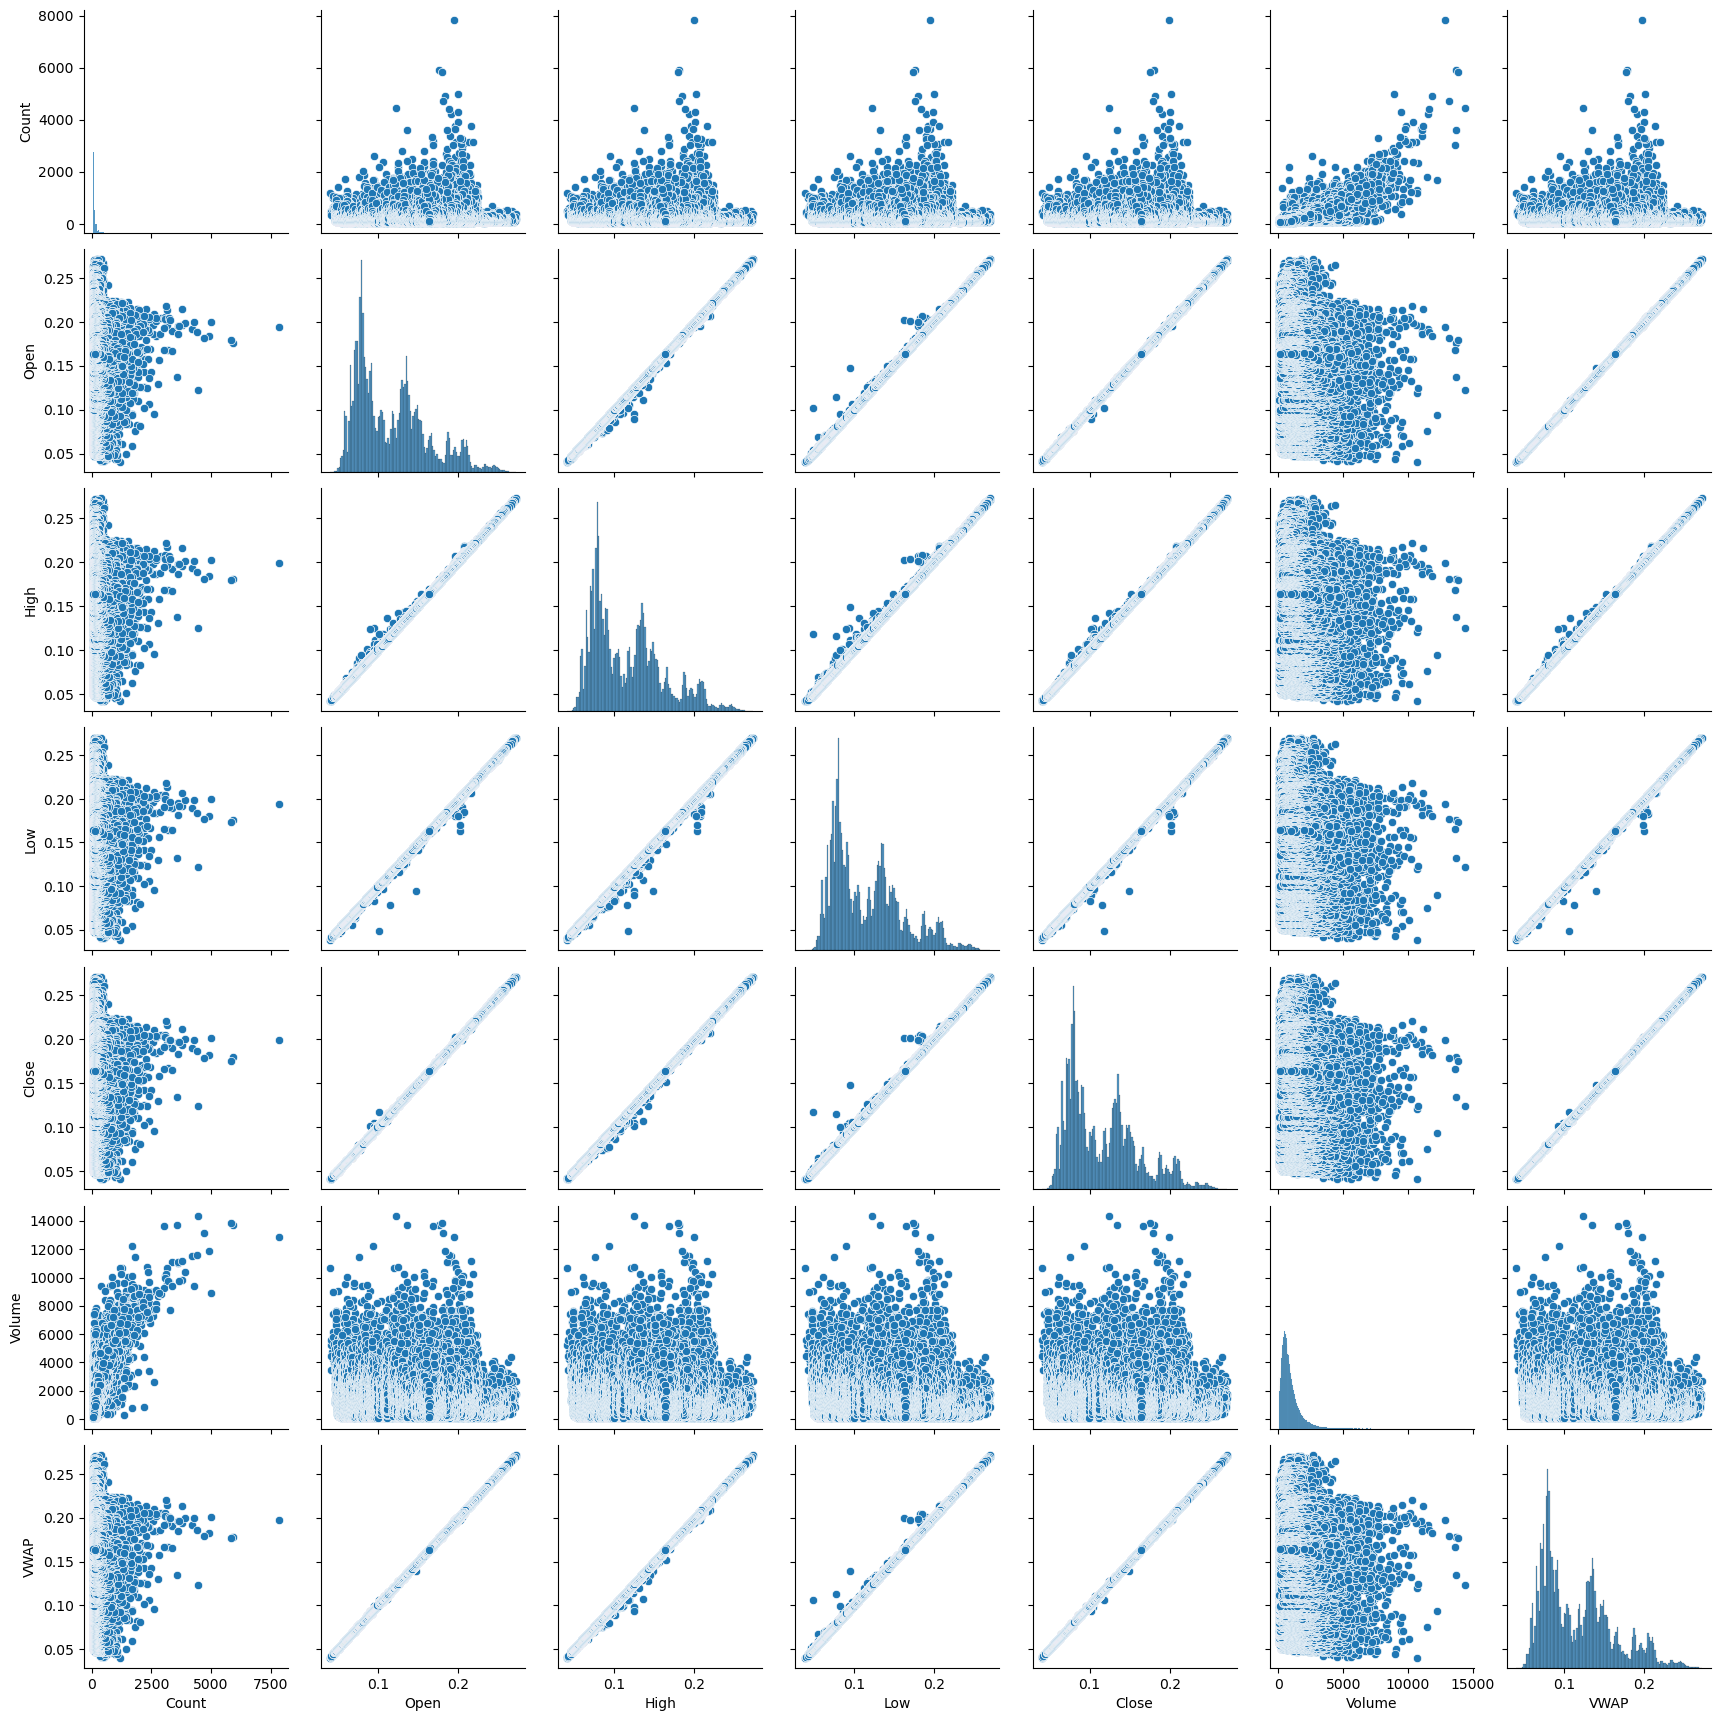

C:\Users\ritap\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


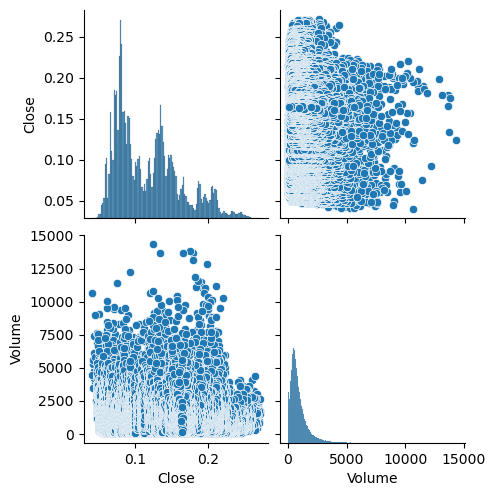

In [9]:
sns.pairplot(train[['Close','Volume']])
plt.show()